출처 : https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

**1. Goal** : build a model that predicts the total ride duration of taxi trips in New York City

뉴욕 시내의 택시들의 승객 이동시간을 예측하는 것

**2. 평가 방식** : RMSLE > 0에 가까울수록 정확도 높다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import pickle



In [ ]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.zip')
test.shape

In [ ]:
# 날짜형 변환
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train.head()

In [ ]:
# 결측값 check > 없음
train.isnull().sum()

In [ ]:
# 데이터셋의 time period check
# 1월1일 ~ 6월 30일까지의 taxi trip data
print('Min pickup time:', min(train['pickup_datetime']))
print('Max pickup time:', max(train['pickup_datetime']))

In [ ]:
# Create new day, month, hour info from Pickup time
# 시계열 자료 > 따로 분리
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
# 오늘의 요일 알아내기 calendar.day_name[my_date.weekday()] 
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train['dropoff_date']= train['dropoff_datetime'].dt.date
train['dropoff_day']=train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour']=train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week']=train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train[['pickup_date','pickup_day', 'pickup_hour', 'pickup_day_of_week','dropoff_datetime','dropoff_day', 'dropoff_hour', 'dropoff_day_of_week']].head()

In [ ]:
# Round lat lng to 3 decimal places
# 위도 경도 반올림
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x: round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

위도 경도 사이의 거리 구하기
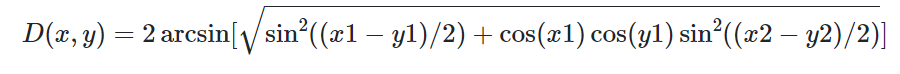


In [ ]:
# 위도, 경도 기반 주행거리(km) 구하기
# haversine_distances 이용
def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance
    

In [ ]:
train['trip_distance'] = train.apply(lambda row: calculateDistance(row), axis=1)
train.head()

In [ ]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x/3600)
train.head()

In [ ]:
# 탐색적 분석
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel('Trip Duration (in hour)')

In [ ]:
# 24시간 이상의 trip duration 존재 > 이상치

outlier_trip_duration = train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

There are 4 records which have very high trip duration, but the distance travelled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let us take log transformation.

We will not remove these from the analysis, because they might be a part of test data as well


- 주행 기간이 매우 길지만 주행 거리는 매우 짧다.
* trip duration : skewed > log transformation 
- 위 여행들이 시작되거나 끝나는 특별한 장소가 있을 수도 있다.
* 테스트 데이터의 일부일 수 있기에 제거하지 않는다.

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title('Distribution of Trip Duration')
plt.title('Distribution of Trip duration (sec) in Log Scale')

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec (exp(8)) . This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are within New York

- 정규화 변환
- 대부분의 여행 54초 ~ 2980초(약 50분)
- 1분 미만이나 100시간 초과된 데이터 살펴야 한다.

#### Heatmap of common locations from where pickup and dropoff occurs

In [ ]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
# NY 위도 경도 
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, np.array(pickup.Num_Trips.values).astype('float64'))),
                     min_opacity=0.2,
                     radius=5, blur=10,
                     max_zoom=1  )
pickup_map.add_child(hm_wide)

pickup_map

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex = True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color = 'blue', label='train', alpha=0.1)
fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

This graph clearly shows heavy density of pickups near JFK
- JFK 공항 근처에 밀도 분포

In [ ]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values,
                           drop.dropoff_longitude_round3.values,
                           np.array(drop.Num_Trips.values).astype('float64'))),
                     min_opacity=0.2,
                     radius=5, blur=10,
                     max_zoom=1)
                  
drop_map.add_child(hm_wide)


drop_map

Dropoff Heatmap is similar to pickup

#### heatmap of trip duration, when pickup originates from a point

In [ ]:
pickup= train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration' : 'Avg_Trip_duration'})

In [ ]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)), 
                 min_opacity=0.2,
                 radius=7, blur=10, max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

The average trip duration, when trip originates from JFK is higher. If we zoom in, we can see that after the Manhattan, The pickups from JFK tend to have higher trip duration.

- JFK에서 pickup하는 trip duration이 더 높다.
- 맨하튼 이후
- 아마 여행

#### Which hours are pickup and dropoff higher?
- 어느 시간대가 승하차가 높을까?

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

The pickups are much lower in the early mornings. Most pickips are around highest between 6 to 8 pm
- 이른 아침에 낮고 저녁 6시부터 8시에 승차를 많이 한다.

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

Distribution of dropoff hour very similar to pickup hour

#### Pickups over the entire time period

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-',label='train')

plt.title('Distribution of Pickups Over time')

There is a drop seen in the number of pick ups in end the January 2016
- 2월 감소
#### What is the distribution of Trip distance
- 주행거리 분포

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

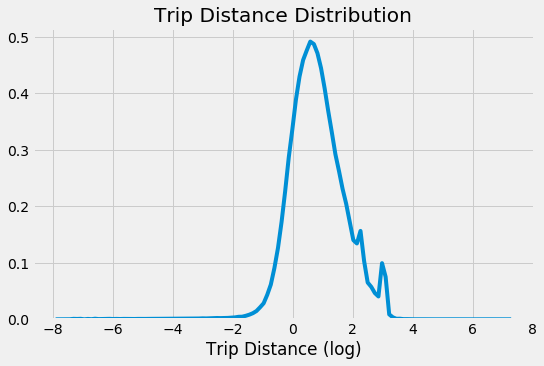

### Trip Duration vs Trip Distance
- 약한 양의 상관관계
- 주행거리 늘어날수록 주행 시간 늘어남

In [ ]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### 시간
#### Is the trip duration higher at different hours?

In [ ]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

Trip duration increases between 10 to 15 hours.
- 10시에서 3시사이 Trip duration 늘어남

### 요일
#### Distribution of Pickups across Days


In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

The number of pickups are very low on Monday.From Tuesday to Friday the number of pickups keep increasing
- 월요일 가장 적고 화요일부터 금요일까지 상승
### 요일별 평균 주행시간
#### Avg Trip Duration over Days of week

In [ ]:
avg_duration_day=train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})


In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_trip_duration',data=avg_duration_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

The highest average speed is on Thursday

#### Create a caluclated field Bearing
Bearing measures the direction of travel The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ is the longitude
- 베어링 공식
- 토지 특성을 식별하거나 사용자의 위치를 정확히 파악하는 데 사용(방향)

In [ ]:
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

In [ ]:
# Bearing 분포
sns.kdeplot(train['bearing'])

In [ ]:
# Bearing vs Trip Duration
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values,y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

The outliers in trip duration are all around bearing -50 degrees

#### Distribution of Store and FWD Flag
store_and_fwd_flag - 이 플래그는 차량이 서버와 연결되지 않았기 때문에 공급업체에 전송하기 전에 트립 레코드를 차량 메모리에 보관했는지 여부를 표시함

In [ ]:
train['store_and_fwd_flag'].value_counts()

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

총 여행의 5~7 시간 사이에 No가 더 많이 분포

#### Group Locations into cluster
This will help creating neighbourhoods. And pickups from certain neightbourhoods may have a longer trip duration

인근지역을 생성하는 데 도움을 준다.

특정 인근지역으로부터 온 pickup들은 아마 더 긴 여행을 할 수도 있다.

---------

**0. clustering?**

비슷한 데이터끼리 모아주는 머신러닝 기법, 패턴이 유사한 사용자를 묶어주는 사용인지에 널리 쓰임.

**1. Algorithm - Kmeans**

KMeans 클러스터링 알고리즘은 n개의 중심점을 찍은 후에, 이 중심점에서 각 점간의 거리의 합이 가장 최소화가 되는 중심점 n의 위치를 찾고, 이 중심점에서 가까운 점들을 중심점을 기준으로 묶는 클러스터링 알고리즘이다.

아래 그림을 보면 3개의 군집이 존재하는 것을 볼 수 있다. 각 군집별로 중심점이 찍혀 있는데, 이 중심점의 위치를 움직여 가면서 각 군집의 데이타와 중심점의 거리가 가장 작은 중심점을 찾는 것이다. 

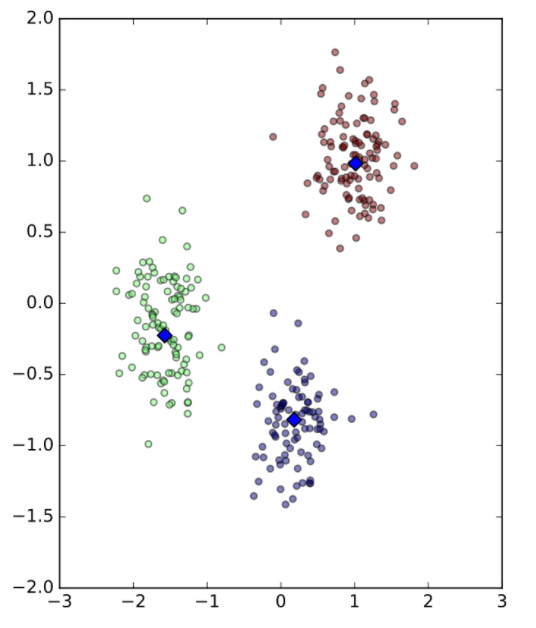

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

#### Number of pickups in each neighbourhood
- 각 지역 안에서 pickup 수


In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

지역 0,3,6 순으로 pickup이 젤 많이 일어난다.

In [ ]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood',y='avg_trip_duration',data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

Neighbourhood 2 has very high average Trip duration, though Neighbourhood 0 has majority of pickups

- 2 지역은 위와 비교했을 때, pickup수에 비해 주행시간이 길다.
- 0 지역은 위와 비교했을 때, 짧은거리 pickup이 대다수다.

### Distribution of Average speed

In [ ]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")


In [ ]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

#### Average Speed across days of week - this is indication of traffic speed.
- 교통속도

In [ ]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_speed_kph',data=avg_speed_per_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

- 평균 주행속도가 일요일과 월요일에 높다.

### Feature Engineering on Test Data

In [ ]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### Building Models

From the training data we need to drop "dropoff datetime features". We also only keep lat lng rounded to 3 decimal places
- dropoff data 삭제

In [ ]:
# ?
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

We have to predict trip_duration. We will convert this to log scale and predict

In [ ]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

In [ ]:
print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Let us also encode day of week as numbers
- 요일 > 숫자로 인코딩


In [ ]:
def encodeDays(day_of_week):
    day_dict = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [ ]:
training['pickup_day_of_week']=training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week']=testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [ ]:
training.to_csv('input_training.csv', index=False)
testing.to_csv("input_testing.csv",index=False)
del training
del testing
del train
del test

In [ ]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
                

def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)
   
    training,testing=LabelEncoding(training,testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [ ]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

In [ ]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',split=0.25,imputation=True):
    labels=np.array(train[target])
    training=train.drop(target, axis = 1)
    training = np.array(training)
    testing=np.array(test)
    if imputation==True:
        imputer=Imputer(strategy=imputing_strategy,missing_values=np.nan)
        imputer.fit(training)
        training=imputer.transform(training)
        testing=imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features,validation_features,train_labels,validation_labels,testing]

# 결측값?

In [ ]:
train_features,validation_features,train_labels,validation_labels,testing=GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

### Apply Linear Regression


In [ ]:
lm=linear_model.LinearRegression()
lm.fit(train_features,train_labels)

In [ ]:
valid_pred=lm.predict(validation_features)

In [ ]:
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

In [ ]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False) #0.64221 on Leader board
del submit

### Apply Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [ ]:
rf.fit(train_features,train_labels)

In [ ]:
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

In [ ]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)